In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [9]:
P = np.array(
    [
        [3.5000, 1.1100, 1.1100, 1.0400, 1.0100],
        [0.5000, 0.9700, 0.9800, 1.0500, 1.0100],
        [0.5000, 0.9900, 0.9900, 0.9900, 1.0100],
        [0.5000, 1.0500, 1.0600, 0.9900, 1.0100],
        [0.5000, 1.1600, 0.9900, 1.0700, 1.0100],
        [0.5000, 0.9900, 0.9900, 1.0600, 1.0100],
        [0.5000, 0.9200, 1.0800, 0.9900, 1.0100],
        [0.5000, 1.1300, 1.1000, 0.9900, 1.0100],
        [0.5000, 0.9300, 0.9500, 1.0400, 1.0100],
        [3.5000, 0.9900, 0.9700, 0.9800, 1.0100],
    ],
    dtype=float,
)

m, n = P.shape
pi = [1] * m

In [3]:
x = cp.Variable(n)
objective = cp.geo_mean(P @ x, pi)
constraints = [cp.sum(x) == 1, x >= 0]
problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve()

np.float64(1.023346685076723)

In [12]:
r_opt = np.log(problem.value)
x_opt = x.value
r_opt, x_opt

(np.float64(0.023078320152124705),
 array([5.79839457e-02, 3.99934981e-01, 2.92097551e-01, 2.49983452e-01,
        7.01766924e-08]))

In [10]:
x_unif = np.ones(n) / n  # uniform resource allocation
r_unif = np.log(cp.geo_mean(P @ x_unif, pi).value)
r_unif

np.float64(0.01137077481839197)

(np.float64(-10.0),
 np.float64(210.0),
 np.float64(-546.7249353226423),
 np.float64(11481.279594586636))

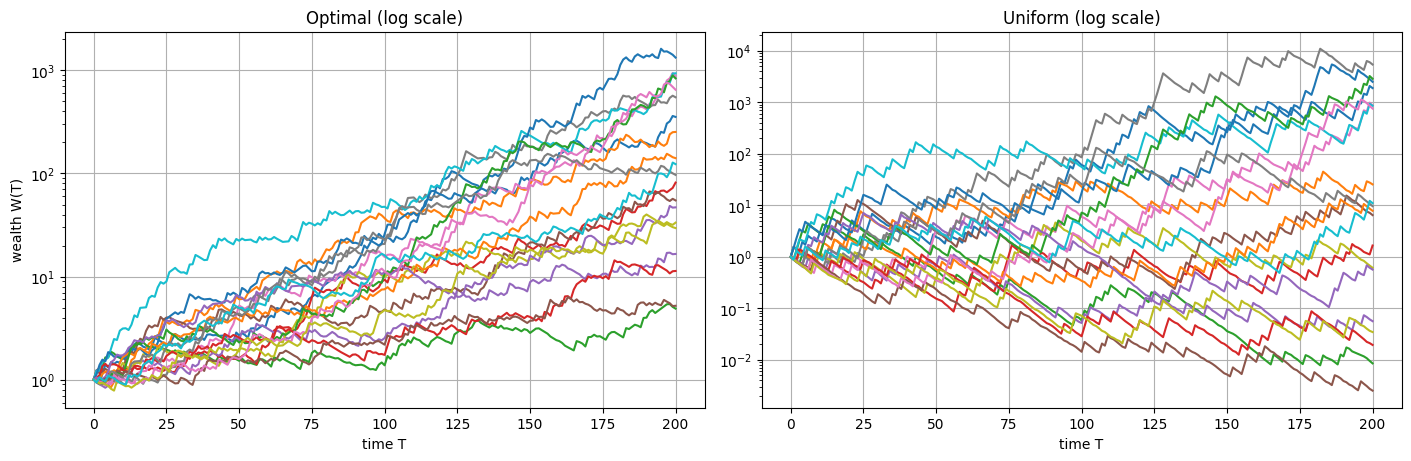

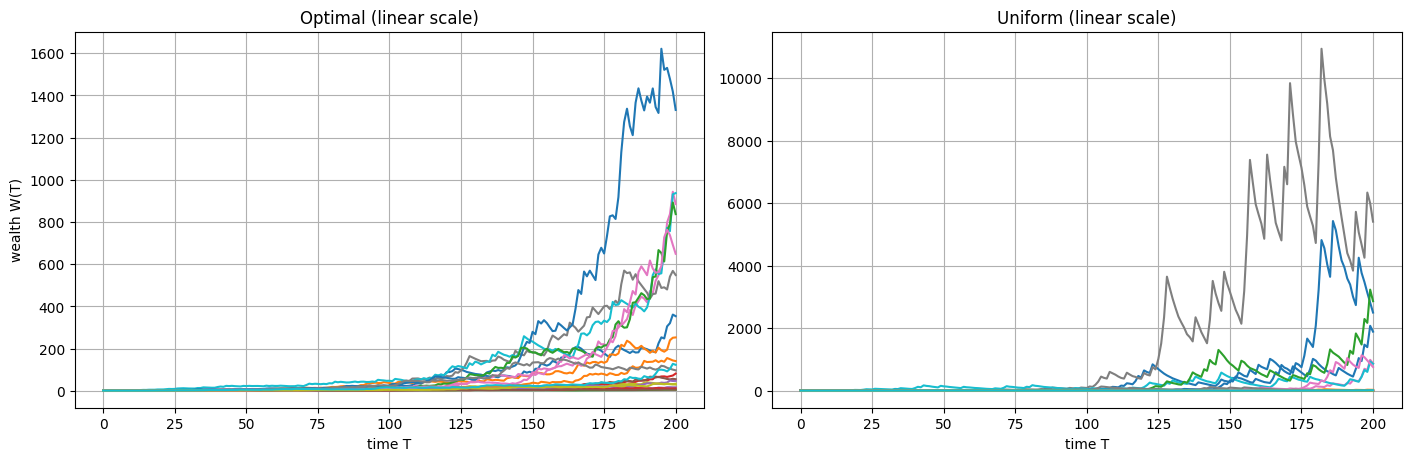

In [19]:
# ====== Inputs expected in your notebook before running ======
# P     : (m, n) scenario-return matrix (gross returns)
# x_opt : (n,) or (n,1) optimal allocation
#
# Optional:
# pi    : (m,) scenario probabilities. If not provided, uses uniform.

# ====== Settings ======
T = 200
W0 = 1.0
n_paths = 20
seed = 0

# ====== Prep ======
P = np.asarray(P, dtype=float)
m, n = P.shape

x_opt = np.asarray(x_opt, dtype=float).reshape(-1)
if x_opt.shape != (n,):
    raise ValueError(f"x_opt should have shape (n,) with n={n}, got {x_opt.shape}")

x_unif = np.ones(n) / n

# scenario distribution
if "pi" in globals():
    pi = np.asarray(pi, dtype=float).reshape(-1)
    if pi.shape != (m,):
        raise ValueError(f"pi should have shape (m,) with m={m}, got {pi.shape}")
    if np.any(pi < 0) or pi.sum() <= 0:
        raise ValueError("pi must be nonnegative and sum to a positive number.")
    pi = pi / pi.sum()
else:
    pi = np.ones(m) / m

rng = np.random.default_rng(seed)

# Use the SAME scenario sequence for both strategies (fair comparison)
events = rng.choice(m, size=(n_paths, T), p=pi)  # entries in {0,...,m-1}


def wealth_paths(P, x, events, W0=1.0):
    """
    P: (m, n)
    x: (n,)
    events: (N, T) scenario indices 0..m-1
    Returns W: (N, T+1) with W[:,0]=W0 and W[:,t]=W(t)
    """
    R = P[events, :]  # (N, T, n)
    lambdas = R @ x  # (N, T)

    # semilogy requires positive values; also log-utility typically assumes positive multipliers
    if np.any(lambdas <= 0):
        bad = np.argwhere(lambdas <= 0)
        i, t = bad[0]
        raise ValueError(
            f"Found nonpositive λ at path {i}, time {t}: λ={lambdas[i,t]}. "
            "Check P and x (gross returns should keep λ>0)."
        )

    W = W0 * np.cumprod(lambdas, axis=1)  # (N, T) for times 1..T
    W = np.concatenate([np.full((W.shape[0], 1), W0), W], axis=1)  # (N, T+1) times 0..T
    return W


W_opt = wealth_paths(P, x_opt, events, W0=W0)
W_unif = wealth_paths(P, x_unif, events, W0=W0)

t = np.arange(T + 1)

# ====== Figure 1: LOG scale ======
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), sharex=True, constrained_layout=True)

for i in range(n_paths):
    ax[0].semilogy(t, W_opt[i])
ax[0].grid(True)
ax[0].set_title("Optimal (log scale)")
ax[0].set_xlabel("time T")
ax[0].set_ylabel("wealth W(T)")
ax[0].axis("tight")

for i in range(n_paths):
    ax[1].semilogy(t, W_unif[i])
ax[1].grid(True)
ax[1].set_title("Uniform (log scale)")
ax[1].set_xlabel("time T")
ax[1].axis("tight")

# ====== Figure 2: LINEAR scale ======
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), sharex=True, constrained_layout=True)

for i in range(n_paths):
    ax[0].plot(t, W_opt[i])
ax[0].grid(True)
ax[0].set_title("Optimal (linear scale)")
ax[0].set_xlabel("time T")
ax[0].set_ylabel("wealth W(T)")
ax[0].axis("tight")

for i in range(n_paths):
    ax[1].plot(t, W_unif[i])
ax[1].grid(True)
ax[1].set_title("Uniform (linear scale)")
ax[1].set_xlabel("time T")
ax[1].axis("tight")